Notebook used to train RF models from the training data.

Comments throughout explain where changes can be made to change what's being trained!

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stat
import numpy as np 
#import forestsci
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter

import sys
sys.path.append("..")
import Utility.model_utils as model_utils

In [24]:
# Runtime Variables
number_trees = 64
seed = 72
min_leaf = 3
accuracy_array = []

# Data Input
filename = '../Results/training_data.csv'

# If saving model, set save to True and give meaningful name
model_name = 'RF_C_MC.sav'
save = True 


# Control what features are used by the model
label="Labels"
features=['area',
#        'equivalent_diameter', 
#        'orientation', 
    'major_axis_length',
    'minor_axis_length',
    'perimeter',
#        'min_intensity',
#        'mean_intensity',
        'max_intensity',
    'solidity',
    'major_axis_length/minor_axis_length',
    'perimeter/major_axis_length',
    'perimeter/minor_axis_length',
          'feret_diameter_max',
      'moments_hu-0',
      'moments_hu-1',
      'moments_hu-2',
      'moments_hu-3',
     # 'moments_hu-4',
      'moments_hu-5',
      #'moments_hu-6',
#    'eccentricity'
         ]


In [25]:
best_f1 = 0
best_model = None
for seed in np.arange(100):
    # Read in data w/ features
    df = pd.read_csv(filename)

    # Modify Data (Remove illegal data OR set different runtime)

    
    # Change how data is grouped
    df['Labels'].replace('Poorly Segmented', 'Incomplete', inplace=True) # Group Poorly Segmented and Incomplete as a single class
    #df['Labels'].replace('Multiple Crystal', 'Crystal', inplace=True) # Group Multiple Crystal and Crystal as a single class
    df = df[df['Labels'] != "Incomplete"] # Remove any data labeled as "Incomplete"
    
    # Missed Labels: Purge any bad data that the model cannot run on
    df['Labels'].replace('', np.nan, inplace=True) 
    df.dropna(subset=['Labels'], inplace=True)
    # Numerical errors (divide by 0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for feature in features:
        df.dropna(subset=[feature],inplace=True)

    # Split Data
    X=df[features]
    y=df[label]
    
    print(Counter(y))

    # Encode
    ohe = OneHotEncoder(sparse=False)
    y = ohe.fit_transform(df[[label]])

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    # Create RandomForestRegressor
    rfr=RandomForestRegressor(n_estimators = number_trees,min_samples_leaf=min_leaf, oob_score=False)
    rfr.fit(X_train,y_train)

    # Accuracy Checks
    y_pred=rfr.predict(X_test)
    y_pred = np.round(y_pred)
    
    accuracy = metrics.f1_score(y_test,y_pred,average='macro')
    accuracy_array.append(accuracy)
    #accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'{seed} Seed Completed')
    model_utils.success_of_guess(y_pred,y_test,ohe)
    print(f'Running Average F1: {np.average(accuracy_array)}, OOB Score: N/A')
    
    if accuracy > best_f1:
        best_model = rfr
        best_f1 = accuracy

Counter({'Crystal': 451, 'Multiple Crystal': 303})
0 Seed Completed
Labels_Crystal -> Precision = 0.9411764705882353, Recall = 0.8888888888888888, F1 = 0.9142857142857143
Labels_Multiple Crystal -> Precision = 0.8484848484848485, Recall = 0.9180327868852459, F1 = 0.8818897637795275
Run Accuracy : 0.9006622516556292
Running Average F1: 0.898087739032621, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
1 Seed Completed
Labels_Crystal -> Precision = 0.9325842696629213, Recall = 0.9120879120879121, F1 = 0.9222222222222223
Labels_Multiple Crystal -> Precision = 0.8709677419354839, Recall = 0.9, F1 = 0.8852459016393444
Run Accuracy : 0.9072847682119205
Running Average F1: 0.9009109004817022, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
2 Seed Completed
Labels_Crystal -> Precision = 0.8571428571428571, Recall = 0.8571428571428571, F1 = 0.8571428571428571
Labels_Multiple Crystal -> Precision = 0.7833333333333333, Recall = 0.7833333333333333, F1 = 0.783333

23 Seed Completed
Labels_Crystal -> Precision = 0.8461538461538461, Recall = 0.9058823529411765, F1 = 0.8749999999999999
Labels_Multiple Crystal -> Precision = 0.8666666666666667, Recall = 0.7878787878787878, F1 = 0.8253968253968254
Run Accuracy : 0.8543046357615894
Running Average F1: 0.8685891390346118, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
24 Seed Completed
Labels_Crystal -> Precision = 0.8282828282828283, Recall = 0.9647058823529412, F1 = 0.8913043478260869
Labels_Multiple Crystal -> Precision = 0.9423076923076923, Recall = 0.7424242424242424, F1 = 0.8305084745762712
Run Accuracy : 0.8675496688741722
Running Average F1: 0.8682818299212743, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
25 Seed Completed
Labels_Crystal -> Precision = 0.875, Recall = 0.9130434782608695, F1 = 0.8936170212765957
Labels_Multiple Crystal -> Precision = 0.8545454545454545, Recall = 0.7966101694915254, F1 = 0.8245614035087718
Run Accuracy : 0.8675496688741722


46 Seed Completed
Labels_Crystal -> Precision = 0.8850574712643678, Recall = 0.875, F1 = 0.8800000000000001
Labels_Multiple Crystal -> Precision = 0.828125, Recall = 0.8412698412698413, F1 = 0.8346456692913385
Run Accuracy : 0.8609271523178808
Running Average F1: 0.8603225144320319, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
47 Seed Completed
Labels_Crystal -> Precision = 0.9354838709677419, Recall = 0.8613861386138614, F1 = 0.8969072164948454
Labels_Multiple Crystal -> Precision = 0.7586206896551724, Recall = 0.88, F1 = 0.8148148148148148
Run Accuracy : 0.8675496688741722
Running Average F1: 0.86022956654084, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
48 Seed Completed
Labels_Crystal -> Precision = 0.8829787234042553, Recall = 0.9325842696629213, F1 = 0.907103825136612
Labels_Multiple Crystal -> Precision = 0.8947368421052632, Recall = 0.8225806451612904, F1 = 0.8571428571428571
Run Accuracy : 0.8874172185430463
Running Average F1: 0.86067

69 Seed Completed
Labels_Crystal -> Precision = 0.8823529411764706, Recall = 0.9183673469387755, F1 = 0.9
Labels_Multiple Crystal -> Precision = 0.8367346938775511, Recall = 0.7735849056603774, F1 = 0.803921568627451
Run Accuracy : 0.8675496688741722
Running Average F1: 0.856934914975752, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
70 Seed Completed
Labels_Crystal -> Precision = 0.8210526315789474, Recall = 0.9176470588235294, F1 = 0.8666666666666667
Labels_Multiple Crystal -> Precision = 0.875, Recall = 0.7424242424242424, F1 = 0.8032786885245902
Run Accuracy : 0.8410596026490066
Running Average F1: 0.856625587688708, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
71 Seed Completed
Labels_Crystal -> Precision = 0.8809523809523809, Recall = 0.891566265060241, F1 = 0.8862275449101796
Labels_Multiple Crystal -> Precision = 0.8656716417910447, Recall = 0.8529411764705882, F1 = 0.8592592592592593
Run Accuracy : 0.8741721854304636
Running Average F1:

92 Seed Completed
Labels_Crystal -> Precision = 0.8690476190476191, Recall = 0.8390804597701149, F1 = 0.8538011695906432
Labels_Multiple Crystal -> Precision = 0.7910447761194029, Recall = 0.828125, F1 = 0.8091603053435115
Run Accuracy : 0.8344370860927153
Running Average F1: 0.8584733304503707, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
93 Seed Completed
Labels_Crystal -> Precision = 0.8921568627450981, Recall = 0.9285714285714286, F1 = 0.9099999999999999
Labels_Multiple Crystal -> Precision = 0.8571428571428571, Recall = 0.7924528301886793, F1 = 0.8235294117647058
Run Accuracy : 0.8807947019867549
Running Average F1: 0.8585615365719874, OOB Score: N/A
Counter({'Crystal': 451, 'Multiple Crystal': 303})
94 Seed Completed
Labels_Crystal -> Precision = 0.8602150537634409, Recall = 0.9090909090909091, F1 = 0.8839779005524862
Labels_Multiple Crystal -> Precision = 0.8620689655172413, Recall = 0.7936507936507936, F1 = 0.8264462809917354
Run Accuracy : 0.86092715231788

In [26]:
print(f'Best Model F1: {best_f1}')
#print(best_model.oob_score_)
print(best_model.score(X_test,y_test))
print(ohe)
print(ohe.feature_names_in_)
ohe.get_feature_names_out(['Labels'])

Best Model F1: 0.9295446061963419
0.7769228844198557
OneHotEncoder(sparse=False)
['Labels']


array(['Labels_Crystal', 'Labels_Multiple Crystal'], dtype=object)

In [27]:
# Feature Importances

from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=seed, n_jobs=4)
elapsed_time = time.time() - start_time

print(f'Time elapsed: {elapsed_time}')
forest_importances = pd.Series(result.importances_mean, index=features)

Time elapsed: 10.439455032348633


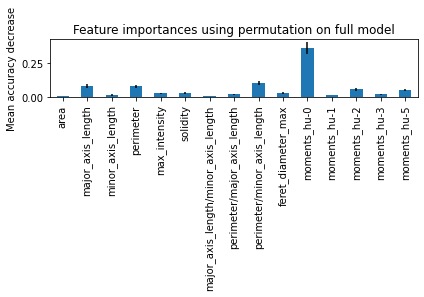

In [28]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [29]:
import pickle
if save:
    pickle.dump(best_model, open(model_name, 'wb'))